Cleaning corrupted images...
Cleanup complete.
Found 3267 images belonging to 2 classes.
Found 816 images belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 840s 8s/step - accuracy: 0.8099 - loss: 0.4321 - val_accuracy: 0.7292 - val_loss: 0.6033
Epoch 2/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 776s 8s/step - accuracy: 0.8776 - loss: 0.3003 - val_accuracy: 0.6446 - val_loss: 0.8434
Epoch 3/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 776s 8s/step - accuracy: 0.9108 - loss: 0.2467 - val_accuracy: 0.7034 - val_loss: 0.7211
Epoch 4/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 771s 7s/step - accuracy: 0.9052 - loss: 0.2264 - val_accuracy: 0.7316 - val_loss: 0.7442
Epoch 5/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 775s 8s/step - accuracy: 0.9242 - loss: 0.2058 - val_accuracy: 0.6740 - val_loss: 0.9509


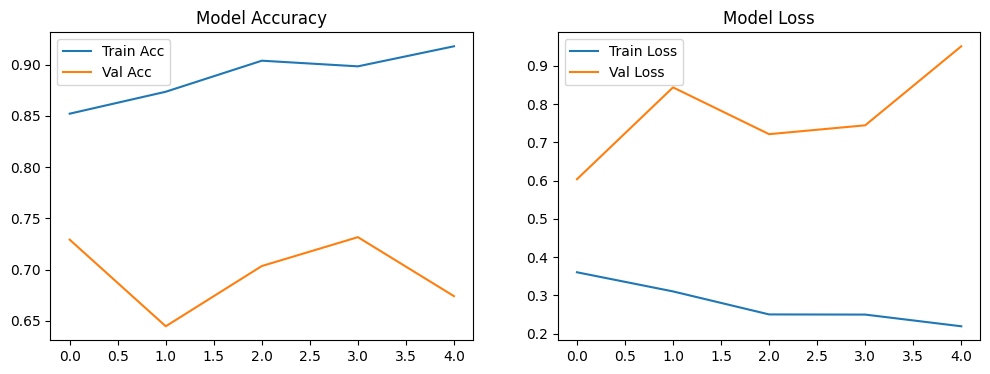

26/26 ━━━━━━━━━━━━━━━━━━━━ 172s 6s/step

Classification Report:

               precision    recall  f1-score   support

    Fractured       0.27      0.52      0.36       143
Non_fractured       0.87      0.71      0.78       673

     accuracy                           0.67       816
    macro avg       0.57      0.61      0.57       816
 weighted avg       0.77      0.67      0.71       816



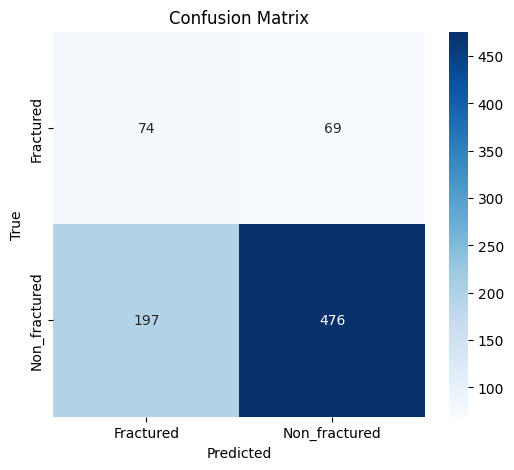

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


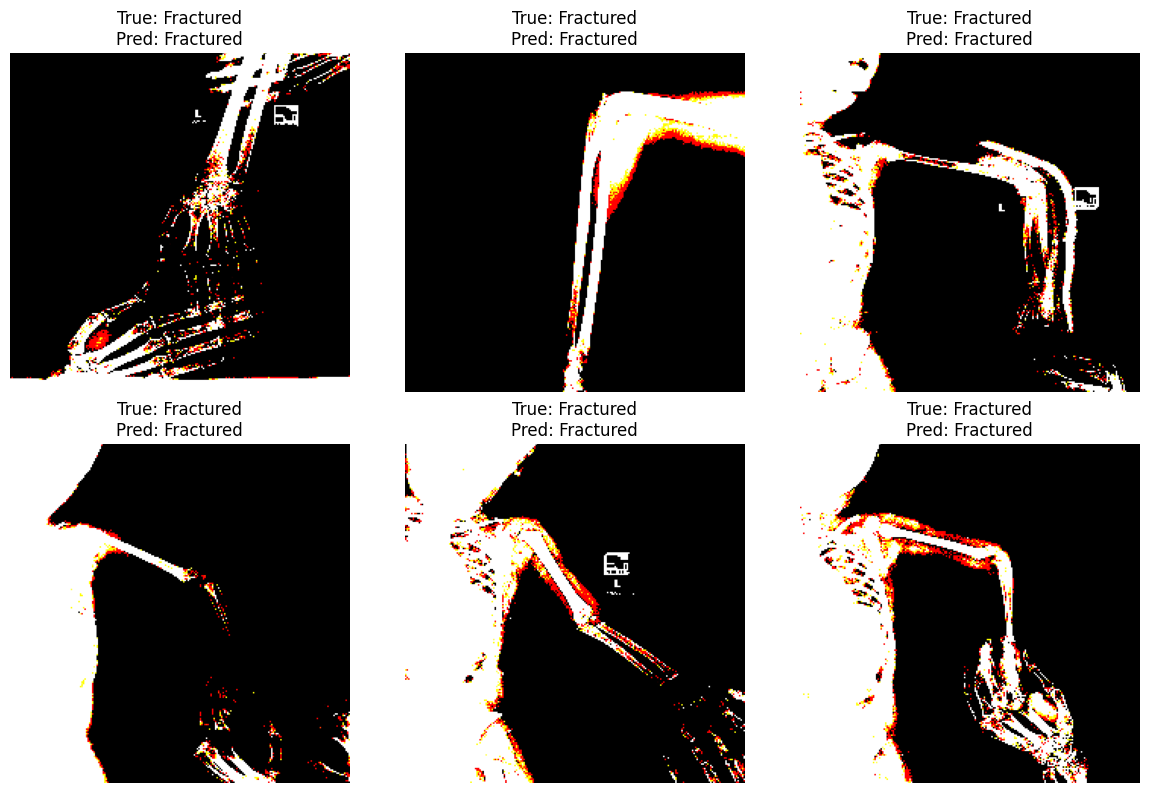

In [ ]:
# =============================
# Step 1: Imports and Cleanup
# =============================
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image, ImageFile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50  # Import ResNet50 instead of EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import glob

# Allow loading of corrupted/truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# =============================
# Step 3: Define Paths
# =============================
fractured_path = '/content/drive/MyDrive/FracAtlas/images/Fractured'
non_fractured_path = '/content/drive/MyDrive/FracAtlas/images/Non_fractured'
root_path = '/content/drive/MyDrive/FracAtlas/images'

# =============================
# Step 4: Clean Corrupted Images
# =============================
print("Cleaning corrupted images...")
for folder in [fractured_path, non_fractured_path]:
    for img_path in glob.glob(folder + '/*'):
        try:
            img = Image.open(img_path)
            img.verify()
        except (IOError, SyntaxError) as e:
            print(f"Corrupted image removed: {img_path}")
            os.remove(img_path)
print("Cleanup complete.")

# =============================
# Step 5: Image Data Generators (Updated for ResNet)
# =============================
datagen = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input  # Preprocessing for ResNet50
)

train_generator = datagen.flow_from_directory(
    root_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    root_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# =============================
# Step 6: ResNet50 Model
# =============================
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Use ResNet50 instead of EfficientNetB0
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# =============================
# Step 7: Train Model
# =============================
history = model.fit(train_generator, epochs=5, validation_data=val_generator)

# =============================
# Step 8: Accuracy/Loss Plots
# =============================
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

# =============================
# Step 9: Confusion Matrix + Report
# =============================
val_generator.reset()
preds = model.predict(val_generator)
y_pred = np.round(preds).astype(int).flatten()
y_true = val_generator.classes

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=['Fractured', 'Non_fractured']))

# Confusion Matrix Heatmap
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fractured', 'Non_fractured'],
            yticklabels=['Fractured', 'Non_fractured'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# =============================
# Step 10: Sample Predictions
# =============================
class_names = ['Fractured', 'Non_fractured']
val_generator.reset()
images, labels = next(val_generator)

plt.figure(figsize=(12, 8))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    pred_label = model.predict(np.expand_dims(images[i], axis=0))[0][0]
    pred_class = class_names[int(round(pred_label))]
    true_class = class_names[int(labels[i])]
    plt.title(f"True: {true_class}\nPred: {pred_class}")
    plt.axis("off")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


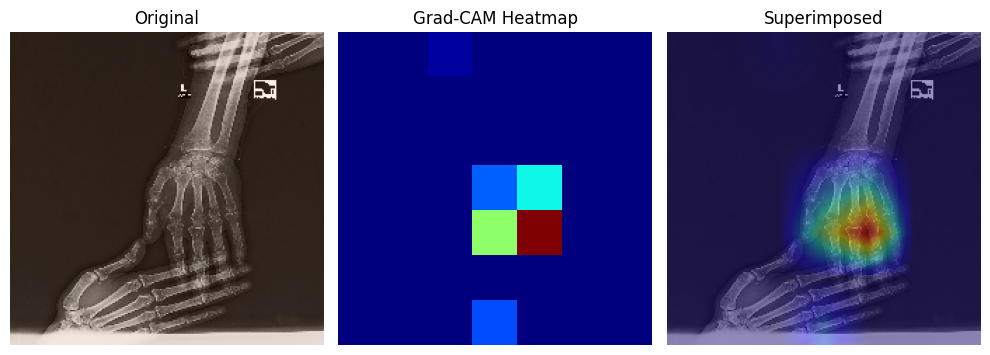

In [ ]:
# =============================
# Step 11: Grad-CAM on a Sample
# =============================

# 1. Get the last convolutional layer in ResNet50
last_conv_layer_name = "conv5_block3_out"

# 2. Create a model that maps input image to activations + predictions
grad_model = tf.keras.models.Model(
    [model.inputs],
    [model.get_layer(last_conv_layer_name).output, model.output]
)

def get_gradcam_heatmap(img_array, pred_index=None):
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Get the gradients of the predicted class
    grads = tape.gradient(class_channel, conv_outputs)

    # Mean of gradients for each channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply pooled grads with the convolutional layer outputs
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_tensor, heatmap, alpha=0.4):
    import cv2
    img = tf.keras.preprocessing.image.array_to_img(img_tensor)
    img = np.array(img)

    # Resize heatmap to image size
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to RGB
    heatmap_rgb = np.uint8(255 * plt.cm.jet(heatmap_resized)[:, :, :3])

    # Superimpose
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_rgb, alpha, 0)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(heatmap, cmap='jet')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Superimposed")
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Pick one sample image from validation set
sample_img = images[0]
img_array = np.expand_dims(sample_img, axis=0)

# Predict and get Grad-CAM
heatmap = get_gradcam_heatmap(img_array)
display_gradcam(sample_img, heatmap)


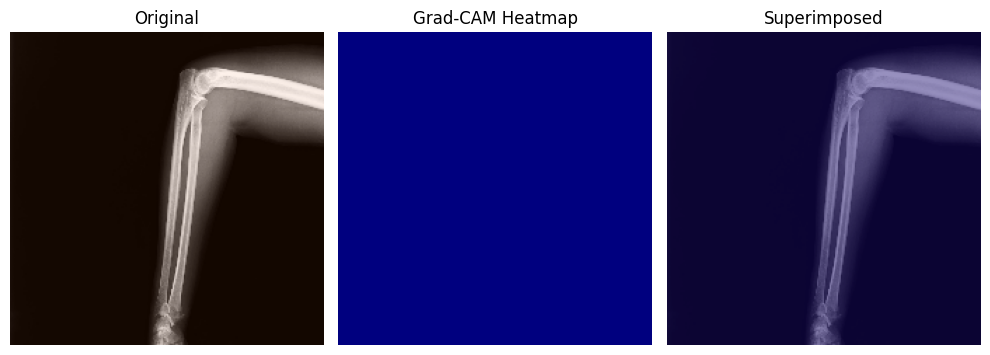

In [ ]:
# =============================
# Step 11: Grad-CAM on a Sample
# =============================

# 1. Get the last convolutional layer in ResNet50
last_conv_layer_name = "conv5_block3_out"

# 2. Create a model that maps input image to activations + predictions
grad_model = tf.keras.models.Model(
    [model.inputs],
    [model.get_layer(last_conv_layer_name).output, model.output]
)

def get_gradcam_heatmap(img_array, pred_index=None):
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Get the gradients of the predicted class
    grads = tape.gradient(class_channel, conv_outputs)

    # Mean of gradients for each channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply pooled grads with the convolutional layer outputs
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_tensor, heatmap, alpha=0.4):
    import cv2
    img = tf.keras.preprocessing.image.array_to_img(img_tensor)
    img = np.array(img)

    # Resize heatmap to image size
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to RGB
    heatmap_rgb = np.uint8(255 * plt.cm.jet(heatmap_resized)[:, :, :3])

    # Superimpose
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_rgb, alpha, 0)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(heatmap, cmap='jet')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Superimposed")
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Pick one sample image from validation set
sample_img = images[1]
img_array = np.expand_dims(sample_img, axis=0)

# Predict and get Grad-CAM
heatmap = get_gradcam_heatmap(img_array)
display_gradcam(sample_img, heatmap)


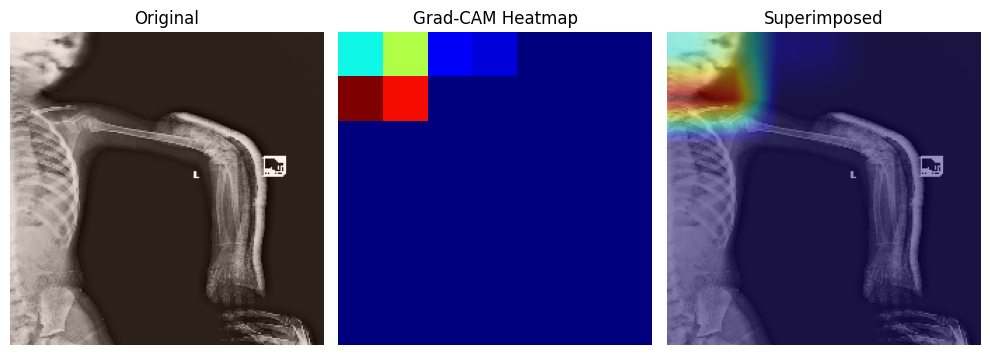

In [ ]:
# =============================
# Step 11: Grad-CAM on a Sample
# =============================

# 1. Get the last convolutional layer in ResNet50
last_conv_layer_name = "conv5_block3_out"

# 2. Create a model that maps input image to activations + predictions
grad_model = tf.keras.models.Model(
    [model.inputs],
    [model.get_layer(last_conv_layer_name).output, model.output]
)

def get_gradcam_heatmap(img_array, pred_index=None):
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Get the gradients of the predicted class
    grads = tape.gradient(class_channel, conv_outputs)

    # Mean of gradients for each channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply pooled grads with the convolutional layer outputs
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_tensor, heatmap, alpha=0.4):
    import cv2
    img = tf.keras.preprocessing.image.array_to_img(img_tensor)
    img = np.array(img)

    # Resize heatmap to image size
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to RGB
    heatmap_rgb = np.uint8(255 * plt.cm.jet(heatmap_resized)[:, :, :3])

    # Superimpose
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_rgb, alpha, 0)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(heatmap, cmap='jet')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Superimposed")
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Pick one sample image from validation set
sample_img = images[2]
img_array = np.expand_dims(sample_img, axis=0)

# Predict and get Grad-CAM
heatmap = get_gradcam_heatmap(img_array)
display_gradcam(sample_img, heatmap)


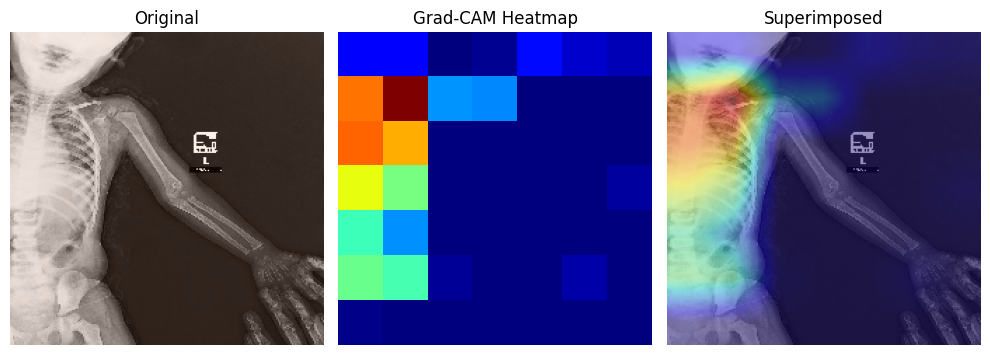

In [ ]:
# =============================
# Step 11: Grad-CAM on a Sample
# =============================

# 1. Get the last convolutional layer in ResNet50
last_conv_layer_name = "conv5_block3_out"

# 2. Create a model that maps input image to activations + predictions
grad_model = tf.keras.models.Model(
    [model.inputs],
    [model.get_layer(last_conv_layer_name).output, model.output]
)

def get_gradcam_heatmap(img_array, pred_index=None):
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Get the gradients of the predicted class
    grads = tape.gradient(class_channel, conv_outputs)

    # Mean of gradients for each channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply pooled grads with the convolutional layer outputs
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize between 0 and 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_tensor, heatmap, alpha=0.4):
    import cv2
    img = tf.keras.preprocessing.image.array_to_img(img_tensor)
    img = np.array(img)

    # Resize heatmap to image size
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to RGB
    heatmap_rgb = np.uint8(255 * plt.cm.jet(heatmap_resized)[:, :, :3])

    # Superimpose
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_rgb, alpha, 0)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(heatmap, cmap='jet')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Superimposed")
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Pick one sample image from validation set
sample_img = images[4]
img_array = np.expand_dims(sample_img, axis=0)

# Predict and get Grad-CAM
heatmap = get_gradcam_heatmap(img_array)
display_gradcam(sample_img, heatmap)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


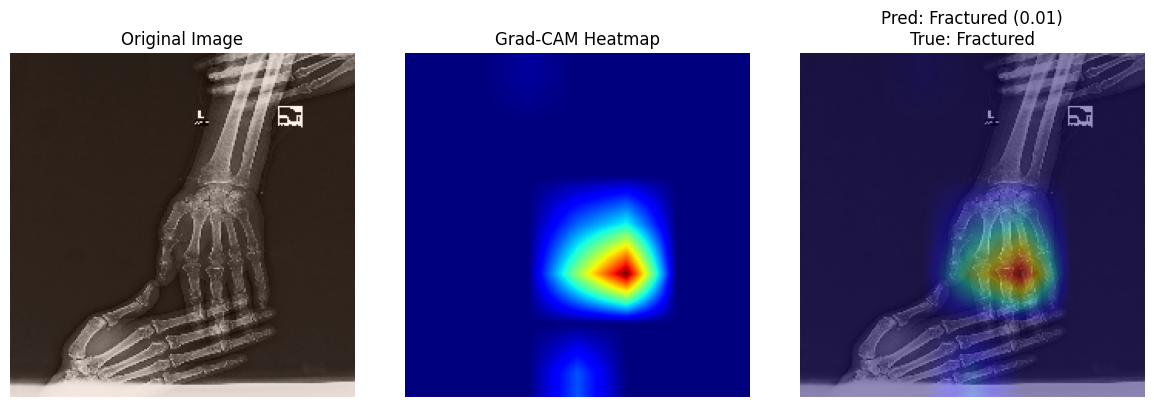

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


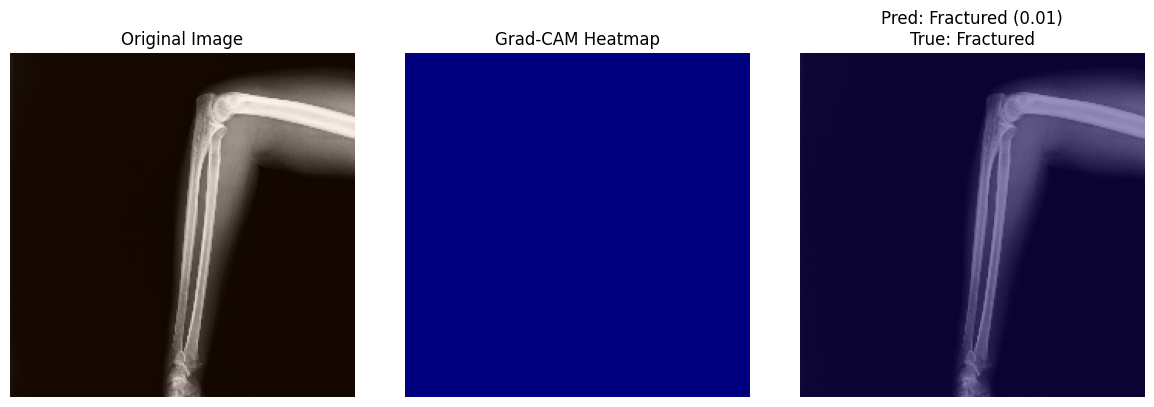

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


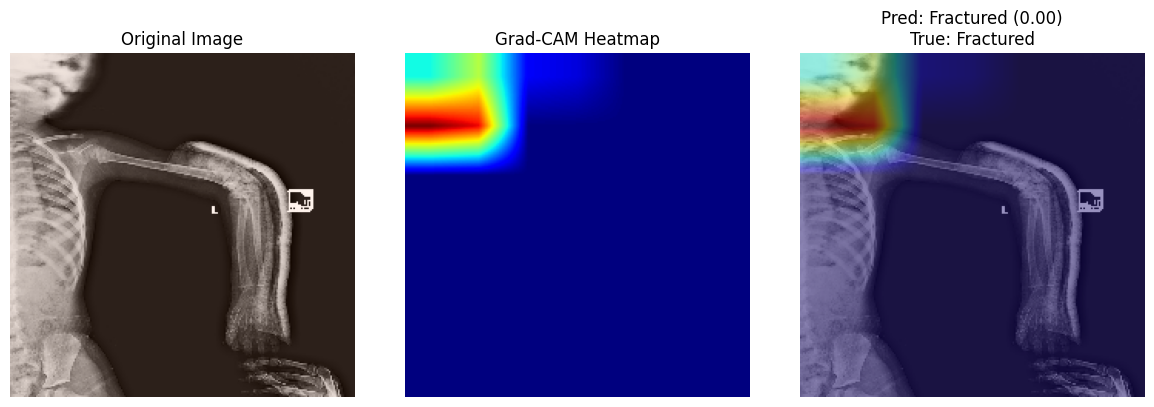

In [ ]:
# =============================
# Step 11: Grad-CAM with Class Labels
# =============================

# Class names
class_names = ['Fractured', 'Non_fractured']
last_conv_layer_name = "conv5_block3_out"

# Model to output conv features and prediction
grad_model = tf.keras.models.Model(
    [model.inputs],
    [model.get_layer(last_conv_layer_name).output, model.output]
)

def get_gradcam_heatmap(img_array, pred_index=None):
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_tensor, heatmap, pred_label, true_label, confidence, alpha=0.4):
    import cv2
    img = tf.keras.preprocessing.image.array_to_img(img_tensor)
    img = np.array(img)

    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_rgb = np.uint8(255 * plt.cm.jet(heatmap_resized)[:, :, :3])
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_rgb, alpha, 0)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_resized, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title(f"Pred: {pred_label} ({confidence:.2f})\nTrue: {true_label}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# =============================
# Apply to a few validation images
# =============================
val_generator.reset()
images, labels = next(val_generator)

for i in range(3):  # Show 3 examples
    img = images[i]
    label = int(labels[i])
    img_array = np.expand_dims(img, axis=0)
    prediction = model.predict(img_array)[0][0]
    pred_label_index = int(round(prediction))
    heatmap = get_gradcam_heatmap(img_array, pred_index=pred_label_index)

    display_gradcam(
        img_tensor=img,
        heatmap=heatmap,
        pred_label=class_names[pred_label_index],
        true_label=class_names[label],
        confidence=prediction
    )


In [ ]:
def display_gradcam(img_tensor, heatmap, pred_label, true_label, alpha=0.4):
    import cv2
    img = tf.keras.preprocessing.image.array_to_img(img_tensor)
    img = np.array(img)

    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_rgb = np.uint8(255 * plt.cm.jet(heatmap_resized)[:, :, :3])
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_rgb, alpha, 0)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_resized, cmap='jet')
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title(f"Predicted: {pred_label}\nTrue: {true_label}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


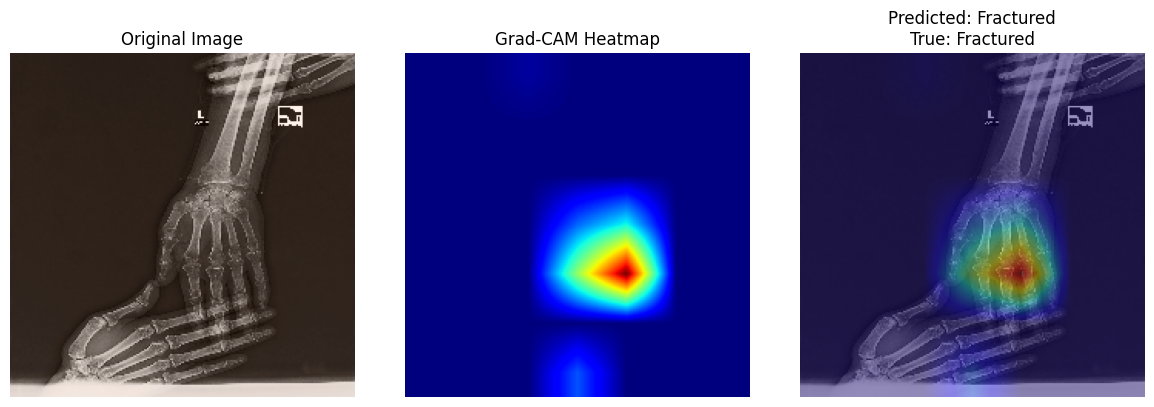

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


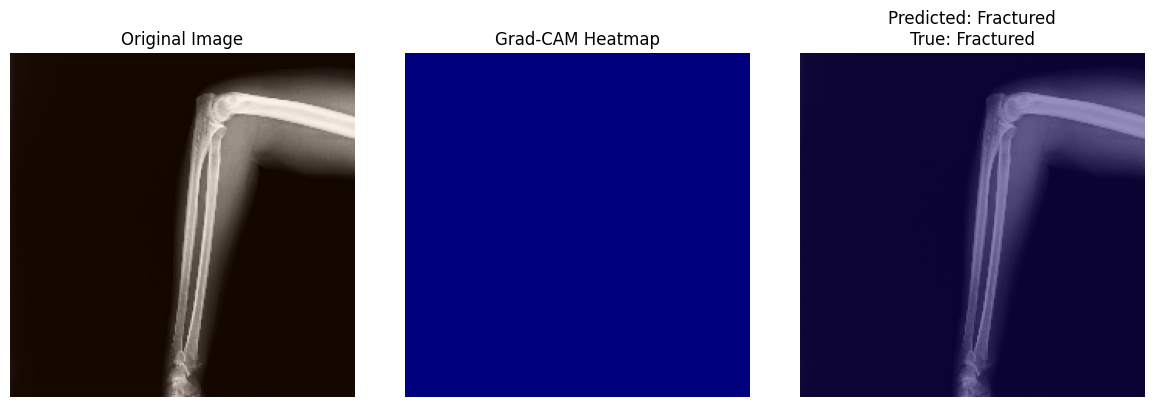

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


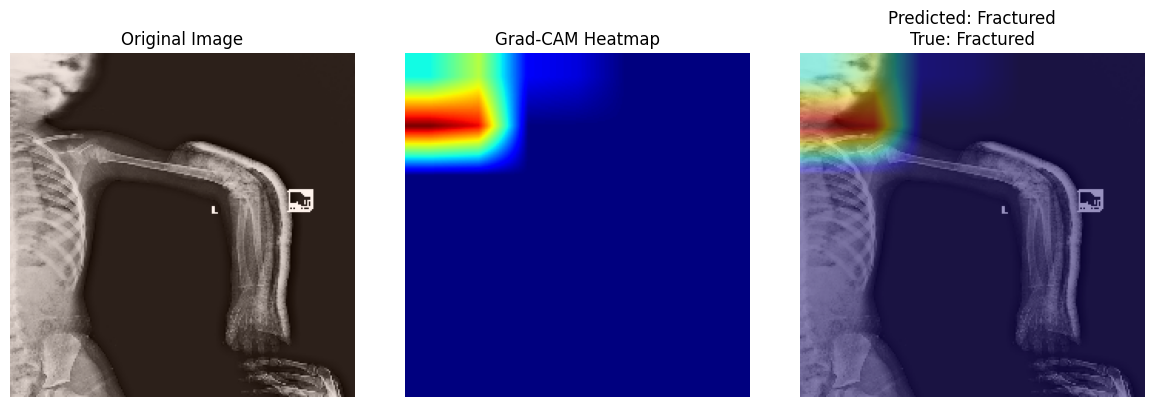

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


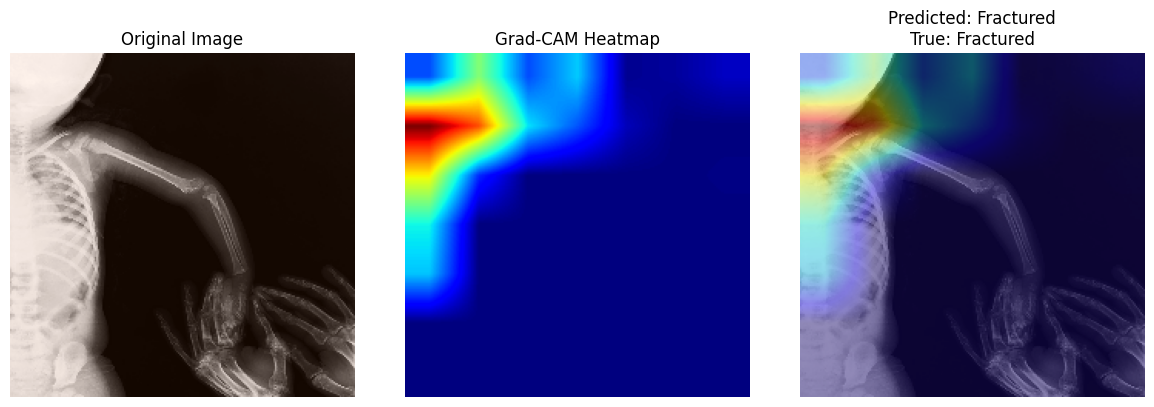

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


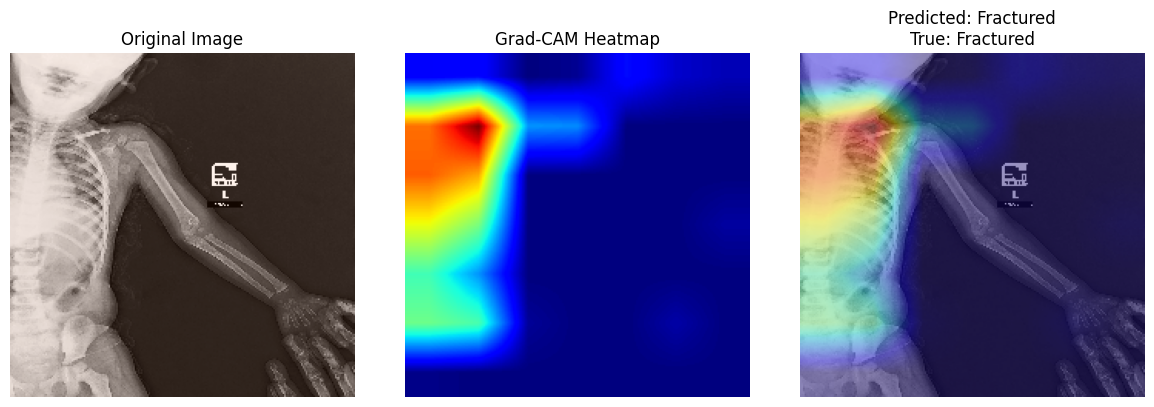

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


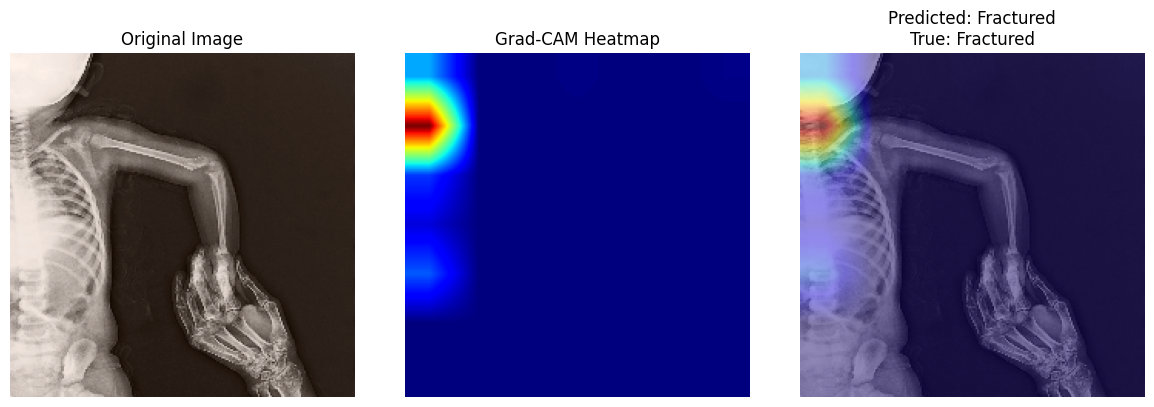

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


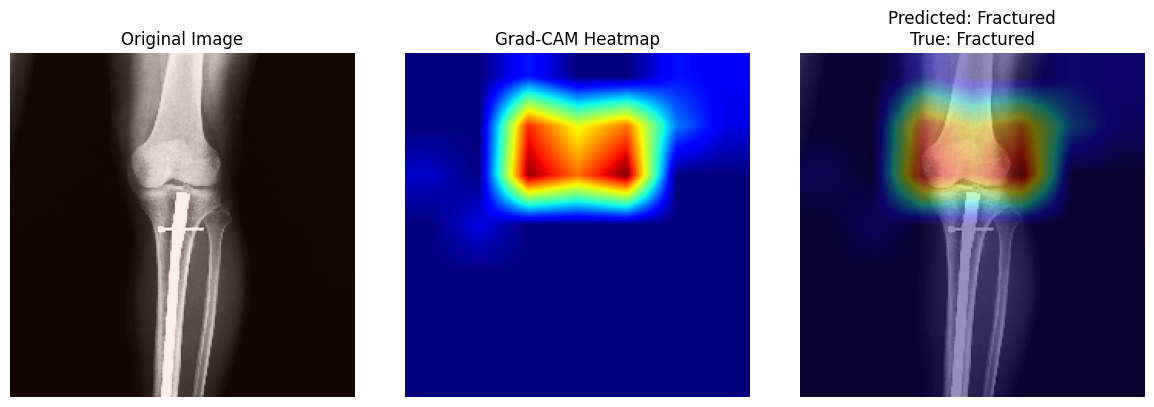

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


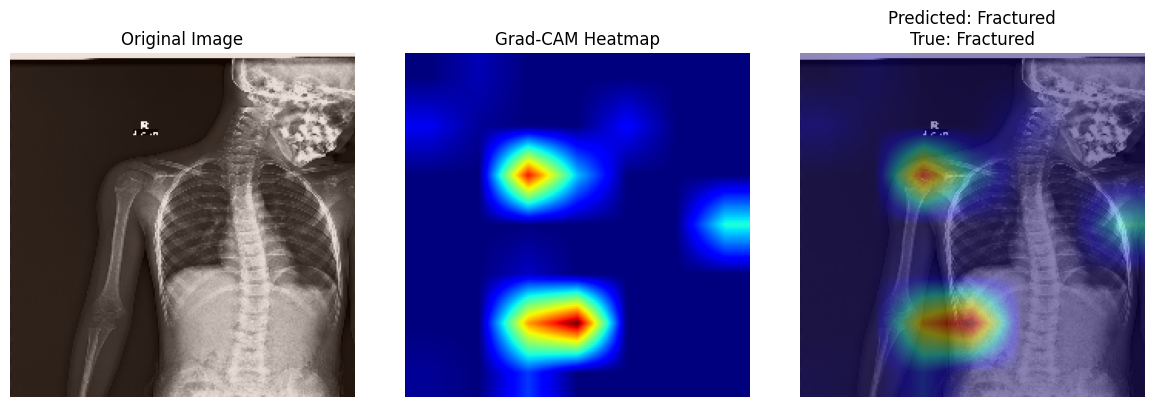

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


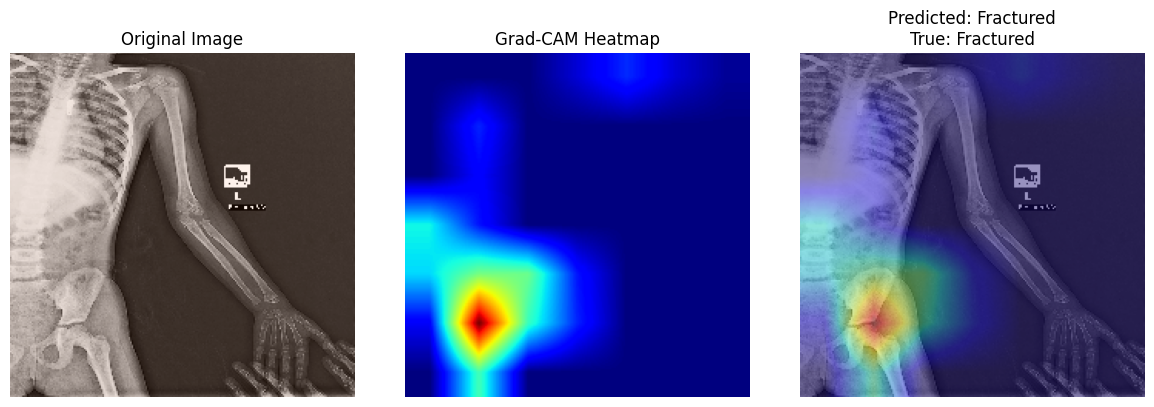

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


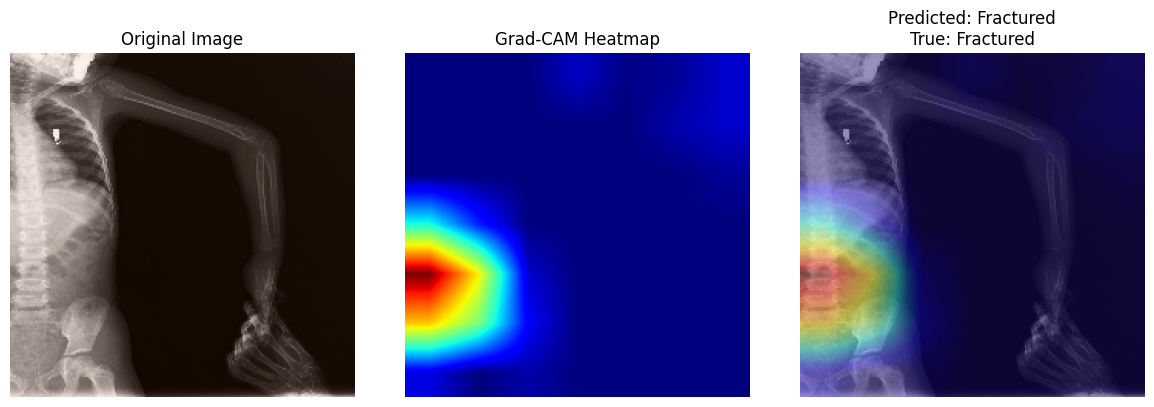

In [ ]:
val_generator.reset()
images, labels = next(val_generator)

for i in range(10):  # Show 3 Grad-CAM results
    img = images[i]
    label = int(labels[i])
    img_array = np.expand_dims(img, axis=0)
    prediction = model.predict(img_array)[0][0]
    pred_label_index = int(round(prediction))
    heatmap = get_gradcam_heatmap(img_array, pred_index=pred_label_index)

    display_gradcam(
        img_tensor=img,
        heatmap=heatmap,
        pred_label=class_names[pred_label_index],
        true_label=class_names[label]
    )
